In [1]:
!pip install imutils

In [ ]:
!pip install pygame

# Importing all the libraries

In [22]:
#Required Packages
import warnings  #  to warn programmers about changes in language or library features 

import dlib # for face detection and shape prediction
import cv2 # OpenCV (Computer Vision) came with both cv and cv2. Now cv is a subclass inside cv2. cv2 is the latest 
from imutils import face_utils # to make basic image processing functions such as translation, rotation, resizing, 
                             # skeletonization, displaying Matplotlib images, sorting contours, detecting edges,etc
    
from scipy.spatial import distance # Distance metrics are contained in the scipy.spatial.distance submodule
import math 
import numpy as np # support for large, multi-dimensional arrays and matrices, large collection of high-level mathematical functions to operate on these arrays
import pandas as pd # for data manipulation and analysis, for manipulating numerical tables and time series


                 # in anticipation of backwards incompatible changes coming with Python 3.0

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics # metrics module implements several loss, score, 
                            # and utility functions to measure classification performance
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, f1_score # 1. Compute Receiver operating characteristic (ROC).
                                                # this implementation is restricted to the binary classification task
                                                # 2. Compute Area Under the Receiver Operating Characteristic Curve 
                                                # (ROC AUC) from prediction scores.
                                                # 3. F1 score, also known as balanced F-score or F-measure. 
                                                # F1 = 2 * (precision * recall) / (precision + recall)
from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns  # data visualization library based on matplotlib. 
                    # It provides a high-level interface for drawing attractive and informative statistical graphics
from sklearn import preprocessing
import pygame  # to play alarm.wav
import time

# define functions for EAR, MAR, PUC, MOE, Average of 3 consecutive outputs of predections

In [23]:
#Feature Functions

def eye_aspect_ratio(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    ear = (A + B) / (2.0 * C)
    return ear

def mouth_aspect_ratio(mouth):
    A = distance.euclidean(mouth[2], mouth[10])
    B = distance.euclidean(mouth[4], mouth[8])
    C = distance.euclidean(mouth[0], mouth[6])
    mar = (A + B) / (2.0 * C)
    return mar

def pupil_circularity(eye):
    A = distance.euclidean(eye[1], eye[4])
    radius  = A/2.0
    Area = math.pi * (radius ** 2)
    p = 0
    p += distance.euclidean(eye[0], eye[1])
    p += distance.euclidean(eye[1], eye[2])
    p += distance.euclidean(eye[2], eye[3])
    p += distance.euclidean(eye[3], eye[4])
    p += distance.euclidean(eye[4], eye[5])
    p += distance.euclidean(eye[5], eye[0])
    return 4 * math.pi * Area /(p**2)

def mouth_over_eye(eye, mouth):
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(mouth)
    moe = mar/ear
    return moe


def average(y_pred):
    for i in range(len(y_pred)):
        if i % 240 == 0  or i % 240 == 1  or i % 240 == 2 or i % 240 == 3 or i % 240 == 4  or i % 240 == 5 or i % 240 == 6  or i % 240 == 7  or i % 240 == 8: # skipping 1st - 9th frames from each video
            continue
        consecutive_10_predictions = y_pred[i-9:i+1]   
        average = consecutive_10_predictions.mean() # each frame's 9th previous to ifself's labels' average will be used for new label 
        if average >= 0.5:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    return y_pred

# Read the dataset and split into train and test sets

In [24]:
#Read in the Data file to Train Model
df = pd.read_csv('Dataset/total_persons_main_info.csv',sep=',')
df = df.drop(df.columns[0],axis=1)

train_percentage = 20/25
train_index = int(len(df)*train_percentage)
test_index = len(df)-train_index

df_train = df[:train_index]
df_test = df[-test_index:]

X_test = df_test.drop(["Label"],axis=1)
y_test = df_test["Label"]

X_train = df_train.drop('Label',axis=1)
y_train = df_train['Label']

## 1. [Logistic Regression - 1](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc)
## 2. [Logistic Regression - 2](https://towardsdatascience.com/logistic-regression-explained-and-implemented-in-python-880955306060)
##  <img src="https://miro.medium.com/max/1400/1*RqXFpiNGwdiKBWyLJc_E7g.png" style = "width: 40vw"> ## 

In [25]:
clf_LR = LogisticRegression()
clf_LR.fit(X_train, y_train)

LogisticRegression()

## 2. [Naive Bayes](https://iq.opengenus.org/gaussian-naive-bayes/#:~:text=Gaussian%20Naive%20Bayes%20is%20a,distribution%20and%20supports%20continuous%20data.&text=Naive%20Bayes%20are%20a%20group,technique%2C%20but%20has%20high%20functionality) ##
## <img src="https://iq.opengenus.org/content/images/2020/02/Screenshot_6.jpg"> ##

In [26]:
clf_NB = GaussianNB()
clf_NB.fit(X_train, y_train)

GaussianNB()

## 3. [KNN](https://towardsdatascience.com/machine-learning-basics-with-the-k-nearest-neighbors-algorithm-6a6e71d01761)

In [27]:
acc3_list = []
f1_score3_list = []
roc_3_list = []
for i in range(1,30):
    neigh = KNeighborsClassifier(n_neighbors=i)
    neigh.fit(X_train, y_train) 
    pred_KN = neigh.predict(X_test)
    pred_KN = average(pred_KN)
    y_score_3 = neigh.predict_proba(X_test)[:,1]
    acc3_list.append(accuracy_score(y_test, pred_KN))
    f1_score3_list.append(metrics.f1_score(y_test, pred_KN))
    roc_3_list.append(metrics.roc_auc_score(y_test, y_score_3))
    
neigh = KNeighborsClassifier(n_neighbors=acc3_list.index(max(acc3_list))+1)
neigh.fit(X_train, y_train) 

KNeighborsClassifier(n_neighbors=15)

## 4. [Decision Tree](https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052)

In [28]:
from sklearn.tree import DecisionTreeClassifier
acc4=[]
max_depth = []
for i in range(2, 10):
    clf_DT = DecisionTreeClassifier(random_state=0, max_depth = i)
    clf_DT.fit(X_train, y_train)
    pred_DT = clf_DT.predict(X_test)
    pred_DT = average(pred_DT)
    acc4.append(accuracy_score(pred_DT, y_test))
    max_depth.append(i)

best_depth_4 = max_depth[acc4.index(max(acc4))]

clf_DT = DecisionTreeClassifier(random_state=0, max_depth = best_depth_4)
clf_DT.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, random_state=0)

## 5. [Random Forest](https://www.javatpoint.com/machine-learning-random-forest-algorithm)

In [29]:
acc5=[]
max_depth = []
for i in range(2, 10):
    clf_RF = RandomForestClassifier(max_depth=i)
    clf_RF.fit(X_train, y_train) 
    pred_RF = clf_RF.predict(X_test)
    pred_RF = average(pred_RF)
    acc5.append(accuracy_score(pred_RF, y_test))
    max_depth.append(i)

best_depth_5 = max_depth[acc5.index(max(acc5))]

clf_RF = RandomForestClassifier(max_depth=best_depth_5)
clf_RF.fit(X_train, y_train) 

RandomForestClassifier(max_depth=5)

# 6. [XGBoosting](https://towardsdatascience.com/xgboost-theory-and-practice-fb8912930ad6#:~:text=XGBoost%20stands%20for%20eXtreme%20Gradient,power%20and%20ease%20of%20use.) 

In [30]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from numpy import loadtxt
from xgboost import XGBClassifier

clf_XGB = XGBClassifier()
clf_XGB.fit(X_train, y_train)

/Users/Dayan/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:18:43] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# 7. [MLP](https://towardsdatascience.com/deep-neural-multilayer-perceptron-mlp-with-scikit-learn-2698e77155e)

In [31]:
from sklearn.neural_network import MLPClassifier

F1_score_list = []
acc7_list = []
roc_list = []
mlp = []

hidden_units = [10,20,30,40,50,60,70]
optimizer = ['sgd','adam','lbfgs']
activation = ['logistic','tanh','relu']

for j in activation:
    for i in optimizer:
        for k in hidden_units:
            clf_MLP = MLPClassifier(hidden_layer_sizes= k, activation =  j, solver= i)
            clf_MLP.fit(X_train, y_train)
            pred_MLP = clf_MLP.predict(X_test)
            pred_MLP = average(pred_MLP)
            y_score_7 = clf_MLP.predict_proba(X_test)[:,1]
            acc7_list.append(accuracy_score(y_test,pred_MLP))
            roc_list.append(metrics.roc_auc_score(y_test, y_score_7))
            F1_score_list.append(metrics.f1_score(y_test, pred_MLP))
            mlp.append([j,i,k])

min_index = acc7_list.index(max(acc7_list))

clf_MLP = MLPClassifier(hidden_layer_sizes= mlp[min_index][2], activation =  mlp[min_index][0], solver= mlp[min_index][1])
clf_MLP.fit(X_train, y_train)

/Users/Dayan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Dayan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Dayan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Dayan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Dayan/anaconda3/lib/python3.8/sit

/Users/Dayan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Dayan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Dayan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Dayan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/Dayan/anaconda3/lib/python3.8/sit

/Users/Dayan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/Dayan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/Dayan/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1)

MLPClassifier(activation='logistic', hidden_layer_sizes=50)

# 8. [CNN](https://towardsdatascience.com/covolutional-neural-network-cb0883dd6529)

In [32]:
X_train_shaped = np.expand_dims(X_train, axis=2)
X_train_shaped.shape
X_test_shaped = np.expand_dims(X_test, axis=2)
X_test_shaped.shape

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv1D
from keras.optimizers import Adam, RMSprop
from keras.layers import Dropout
## Create Model ##

model = Sequential()

model.add(Conv1D(64, kernel_size = 3, activation = 'relu', input_shape = (8,1)))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1,activation = 'sigmoid'))


## Compile Model ##
optimizer = Adam(lr=0.00001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

## Train Model and Check Validation Accuracy ##
model.fit(X_train_shaped, y_train, validation_data = (X_test_shaped,y_test), epochs = 100)

Epoch 1/100
300/300 [==============================] - 1s 3ms/step - loss: 0.6857 - accuracy: 0.5514 - val_loss: 0.6935 - val_accuracy: 0.5617
Epoch 2/100
300/300 [==============================] - 1s 2ms/step - loss: 0.6621 - accuracy: 0.5978 - val_loss: 0.6922 - val_accuracy: 0.5813
Epoch 3/100
300/300 [==============================] - 1s 2ms/step - loss: 0.6613 - accuracy: 0.6081 - val_loss: 0.6914 - val_accuracy: 0.5808
Epoch 4/100
300/300 [==============================] - 1s 2ms/step - loss: 0.6536 - accuracy: 0.6177 - val_loss: 0.6916 - val_accuracy: 0.5458
Epoch 5/100
300/300 [==============================] - 1s 2ms/step - loss: 0.6501 - accuracy: 0.6327 - val_loss: 0.6912 - val_accuracy: 0.5421
Epoch 6/100
300/300 [==============================] - 1s 2ms/step - loss: 0.6511 - accuracy: 0.6329 - val_loss: 0.6896 - val_accuracy: 0.5475
Epoch 7/100
300/300 [==============================] - 1s 2ms/step - loss: 0.6469 - accuracy: 0.6349 - val_loss: 0.6877 - val_accuracy: 0.5508

Epoch 58/100
300/300 [==============================] - 1s 2ms/step - loss: 0.5941 - accuracy: 0.6903 - val_loss: 0.6500 - val_accuracy: 0.6125
Epoch 59/100
300/300 [==============================] - 1s 2ms/step - loss: 0.5943 - accuracy: 0.6898 - val_loss: 0.6491 - val_accuracy: 0.6162
Epoch 60/100
300/300 [==============================] - 1s 2ms/step - loss: 0.5974 - accuracy: 0.6817 - val_loss: 0.6484 - val_accuracy: 0.6192
Epoch 61/100
300/300 [==============================] - 1s 2ms/step - loss: 0.5877 - accuracy: 0.6977 - val_loss: 0.6474 - val_accuracy: 0.6225
Epoch 62/100
300/300 [==============================] - 1s 2ms/step - loss: 0.5853 - accuracy: 0.7009 - val_loss: 0.6461 - val_accuracy: 0.6258
Epoch 63/100
300/300 [==============================] - 1s 2ms/step - loss: 0.5900 - accuracy: 0.6955 - val_loss: 0.6470 - val_accuracy: 0.6225
Epoch 64/100
300/300 [==============================] - 1s 2ms/step - loss: 0.5823 - accuracy: 0.7074 - val_loss: 0.6470 - val_accuracy:

In [12]:
# global variables for further use
mean = pd.DataFrame() 
std = pd.DataFrame()
ten_consecutive_predictions = []

In [33]:
def model_with_result(landmarks, selected_algorithm):
    
    features = pd.DataFrame(columns=["EAR","MAR","PUC","MOE"])

    eye = landmarks[36:48]
    mouth = landmarks[48:68]
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(mouth)
    cir = pupil_circularity(eye)
    mouth_eye = mouth_over_eye(eye, mouth)

    df = features.append({"EAR":ear,"MAR": mar,"PUC": cir,"MOE": mouth_eye},ignore_index=True)
    
    global mean
    global std
    global ten_consecutive_predictions
    
    df["EAR_N"] = (df["EAR"]- mean["EAR"])/ std["EAR"]
    df["MAR_N"] = (df["MAR"]- mean["MAR"])/ std["MAR"]
    df["PUC_N"] = (df["PUC"]- mean["PUC"])/ std["PUC"]
    df["MOE_N"] = (df["MOE"]- mean["MOE"])/ std["MOE"]
    
    if selected_algorithm == '1':
        Result = clf_LR.predict(df)
    elif selected_algorithm == '2':
        Result = clf_NB.predict(df)
    elif selected_algorithm == '3':
        Result = neigh.predict(df)
    elif selected_algorithm == '4':
        Result = clf_DT.predict(df)
    elif selected_algorithm == '5':
        Result = clf_RF.predict(df)
    elif selected_algorithm == '6':
        Result = clf_XGB.predict(df)
    elif selected_algorithm == '7':
        Result = clf_MLP.predict(df)
    elif selected_algorithm == '8':
        np_array = np.expand_dims(df, axis=2)
        Result = model.predict_classes(np_array)
    
    ten_consecutive_predictions.append(Result)
        
    if len(ten_consecutive_predictions) == 10:  
        average = sum(ten_consecutive_predictions) / 10 # each frame's 2nd previous, previous and ifself's label average will be used for new label 
        
        if average >= 0.5:
            Result = 1
        else:
            Result = 0
                
        ten_consecutive_predictions = ten_consecutive_predictions[-9:]
        
    if Result == 1:
        Result_String = "Drowsy"
    elif Result == 0:
        Result_String = "Alert"
    
    return Result_String, df.values

# 1. https://www.quora.com/In-image-processing-applications-why-do-we-convert-from-RGB-to-Grayscale
# 2. https://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/

# 3. <img src="https://www.pyimagesearch.com/wp-content/uploads/2017/04/facial_landmarks_68markup-1024x825.jpg" style="width: 40vw; height: 50vh">

In [34]:
def live_drowsiness_prediction():
    cap = cv2.VideoCapture(0) # VideoCapture(0) function to capture the feed of the webcam here 0 
                              # indicates the default value of webcam.
    data = []
    result = []
    selected_algorithm = ''
    str_headline = 'Please select an algorithm to predict drowsiness'
    previous_time = time.time()
    millisecs = 0
    Result_String = 'Alert'
    
    while True:
        # Getting out image by webcam 
        _, image = cap.read()

        # Converting the image to gray scale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
        
        # waitKey(0) shows a still image until a key is press, waitKey(1) shows a frame for at least 1 ms only
        k = cv2.waitKey(1)
        if k == ord('1'):
            selected_algorithm = '1'
            str_headline = 'Drowsiness Detection using Logistic Regression'
        elif k == ord('2'):
            selected_algorithm = '2'
            str_headline = 'Drowsiness Detection using Naive Bayes'
        elif k == ord('3'):
            selected_algorithm = '3'
            str_headline = 'Drowsiness Detection using KNN'
        elif k == ord('4'):
            selected_algorithm = '4'
            str_headline = 'Drowsiness Detection using Decision Tree'
        elif k == ord('5'):
            selected_algorithm = '5'
            str_headline = 'Drowsiness Detection using Random Forest'
        elif k == ord('6'):
            selected_algorithm = '6'
            str_headline = 'Drowsiness Detection using XGBoosting'
        elif k == ord('7'):
            selected_algorithm = '7'
            str_headline = 'Drowsiness Detection using MLP'
        elif k == ord('8'):
            selected_algorithm = '8'
            str_headline = 'Drowsiness Detection using CNN'

        cv2.putText(image, str_headline, TopMiddleCornerOfText, font, fontScale, fontColor,lineType)
        
        cv2.putText(image, "Press '1' to select Logistic Regression", (10, 20), font, fontScale, fontColor,lineType)
        cv2.putText(image, "Press '2' to select Naive Bayes", (10, 40), font, fontScale, fontColor,lineType)
        cv2.putText(image, "Press '3' to select KNN", (10, 60), font, fontScale, fontColor,lineType)
        cv2.putText(image, "Press '4' to select Decision Tree", (10, 80), font, fontScale, fontColor,lineType)
        cv2.putText(image, "Press '5' to select Random Forest", (10, 100), font, fontScale, fontColor,lineType)
        cv2.putText(image, "Press '6' to select XGBoosting", (10, 120), font, fontScale, fontColor,lineType)
        cv2.putText(image, "Press '7' to select MLP", (10, 140), font, fontScale, fontColor,lineType)
        cv2.putText(image, "Press '8' to select CNN", (10, 160), font, fontScale, fontColor,lineType)
        
        cv2.putText(image,"If you want to close the program press 'Esc'", bottomRightCornerOfText, font, fontScale, fontColor,lineType)
        
        
        if selected_algorithm != '':
            # Get faces into webcam's image
            rects = detector(image, 0) # second parameter is the number of image pyramid layers to apply 
                                       # when upscaling the image prior to applying the detector
            
            # For each detected face, find the landmark.
            for (i, rect) in enumerate(rects):
                # Make the prediction and transfom it to numpy array
                shape = predictor(gray, rect) # giving us the fancial landmarks of 68 (x, y)-coordinates that 
                                              # map to the specific facial features in the image. function 
                                              # returns dlib object
                shape = face_utils.shape_to_np(shape) # converts the dlib shape object to a NumPy array with shape (68, 2)
                
                
                if Result_String == 'Drowsy':
                    cv2.putText(image,Result_String, bottomLeftCornerOfText, font, 1, (0, 0, 255),lineType)
                else:
                    cv2.putText(image,Result_String, bottomLeftCornerOfText, font, 1, (0, 255, 0),lineType)
                
                current_time = time.time()
                
                if current_time - previous_time >= 0.3:
                        
#                         print(millisecs, end='\r')                          
                        previous_time = current_time
                        millisecs += 1
                        Result_String, features = model_with_result(shape, selected_algorithm)
                        
                        data.append (features)
                        result.append(Result_String)
                        
                        pygame.init()
                        if Result_String == 'Drowsy':
                            pygame.mixer.music.load('alarm.wav')
                            pygame.mixer.music.play()
        #                     time.sleep(5)
                        else:
                            pygame.mixer.music.stop()
                     

                # Draw on our image, all the finded cordinate points (x,y) 
                for (x, y) in shape:
                    cv2.circle(image, (x, y), 2, (0, 255, 0), -1) # cv2.circle(image, center_coordinates, radius, color, thickness)
                                                                  # loop over the detected facial landmarks and 
                                                                  # draw each of them individually.

            k = cv2.waitKey(1)
            if k == 27:   # ASCII for esc
                break
        
        # Show the image
        cv2.imshow("Drowsiness and Lethargy Detector", image)


    cv2.destroyAllWindows()
    cap.release()
    
    return data, result

In [35]:
p = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

In [ ]:
import time

font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,600)
bottomRightCornerOfText = (800, 700)
TopMiddleCornerOfText = (500, 15)
fontScale              = 0.6
fontColor              = (255,255,255)
lineType               = 2

# wait for perfect position to start calibration
cap = cv2.VideoCapture(0)

while True:
    # Getting out image by webcam 
    _, image = cap.read() # web
    cv2.putText(image,"Be in proper position and press 's' to start calibration", (750, 700), font, fontScale, fontColor,lineType)
     # Show the image
    cv2.imshow("Drowsiness and Lethargy Detector", image)
    if cv2.waitKey(1) & 0xFF == ord('s'):
        break
# end of waiting 

#Run Calibration
data = []
cap = cv2.VideoCapture(0)

previous_time = time.time()
secs = 0
while secs <= 30:  # Calibrate for 30 secs

    # Getting out image by webcam 
    _, image = cap.read() # web cam image three dimensional nparray size = 1280 * 720 * 3 
    
    cv2.putText(image, 'Counting 30 seconds for calibration: ' + str(secs), bottomRightCornerOfText, font, fontScale, fontColor,lineType)
    
    # Converting the image to gray scale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # gray is two dimensional nparray size = 720, 1280
    # Get faces into webcam's image
    rects = detector(image, 0)  # second parameter is the number of image pyramid layers to apply 
                                # when upscaling the image prior to applying the detector

    # For each detected face, find the landmark.
    for (i, rect) in enumerate(rects):
        # Make the prediction and transfom it to numpy array
        shape = predictor(gray, rect) # giving us the fancial landmarks of 68 (x, y)-coordinates that 
                                      # map to the specific facial features in the image. function 
                                      # returns dlib object
        shape = face_utils.shape_to_np(shape) # converts the dlib shape object to a NumPy array with shape (68, 2)
        data.append(shape)
        cv2.putText(image,"Calibrating...", bottomLeftCornerOfText, font, 1, fontColor,lineType)
        
          # Draw on our image, all the finded cordinate points (x,y) 
        for (x, y) in shape:
            cv2.circle(image, (x, y), 2, (0, 255, 0), -1) # cv2.circle(image, center_coordinates, radius, color, thickness)
                                                          # loop over the detected facial landmarks and 
                                                          # draw each of them individually.

    # Show the image
    cv2.imshow("Drowsiness and Lethargy Detector", image)
    
    cv2.waitKey(1)
    # current time
    current_time = time.time()

    # Update and keep track of Countdown
    # if time elapsed is one second
    # than decrese the counter
    if current_time - previous_time >= 1:
        previous_time = current_time
        secs += 1

features_test = []
for d in data:
    eye = d[36:48]
    mouth = d[48: 68]
    ear = eye_aspect_ratio(eye)
    mar = mouth_aspect_ratio(mouth)
    cir = pupil_circularity(eye)
    mouth_eye = mouth_over_eye(eye, mouth)
    features_test.append([ear, mar, cir, mouth_eye])

features = np.array(features_test)

df = pd.DataFrame(features,columns=["EAR","MAR","PUC","MOE"])

mean = df.mean(axis=0)
std = df.std(axis=0)

#End of Calibration

#Run Demonstration
features, result = live_drowsiness_prediction()

# print('Result = ', result)

# 1. https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
# 2. https://www.python-course.eu/matplotlib_subplots.php

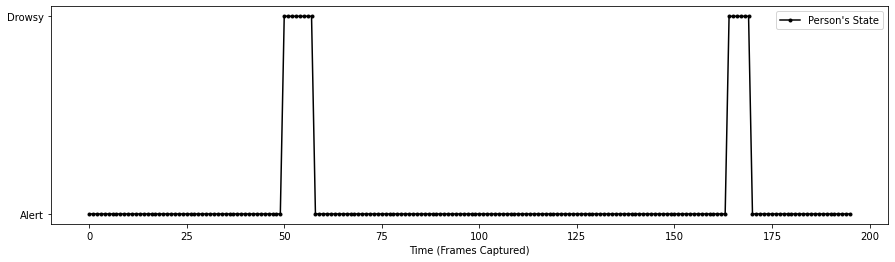

In [19]:
#Plot Results
features = np.vstack(features) # Stack arrays in sequence vertically (row wise).

y = pd.DataFrame(result,columns=["Result"])

y["Result"] = result

fig, ax1 = plt.subplots(nrows=1,       # for each figure 1 row. so total 1 row for total 1 figure
                                ncols=1,
                                sharex=True,  # True or 'all': x- or y-axis will be shared among all subplots.
                                sharey=False,
                                figsize=(15, 4))


ax1.plot(y["Result"], marker = '.', color = "Black", label = "Person's State")
ax1.set_xlabel('Time (Frames Captured)')
ax1.legend()